In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [6]:
DATASET = DatasetSchema.load_schema('house-of-representatives-congress-116')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

In [7]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [8]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

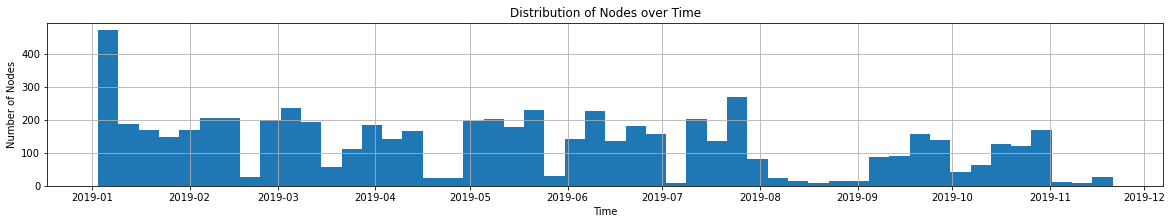

In [9]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [10]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [11]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 6986
Number of Edges: 404528
Density: 0.008289982152668154


In [12]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [13]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 115.81105067277412
Median Degree: 11.0


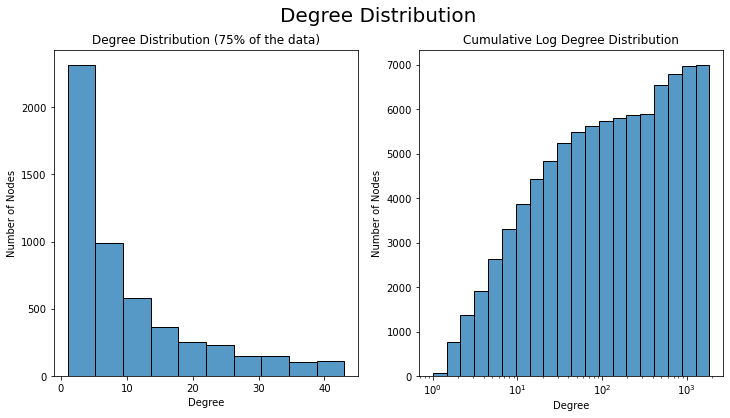

In [14]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [15]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,1862,eleanor-norton
1,1464,brian-fitzpatrick
2,1433,steve-cohen
3,1410,james-mcgovern
4,1399,janice-schakowsky
5,1377,sheila-jackson-lee
6,1377,jamie-raskin
7,1344,raul-grijalva
8,1322,alcee-hastings
9,1290,barbara-lee


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [16]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [17]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.019
Diameter: 4


In [18]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

Eigenvector Centrality Error: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')


,degree_centrality,betweenness_centrality,page_rank,transitivity
count,6986.000000,6986.000000,6986.000000,6911.000000
mean,0.016541,0.000243,0.000143,0.028229
std,0.034692,0.000642,0.000275,0.101214
min,0.000143,0.000000,0.000022,0.000000
25%,0.000573,0.000000,0.000029,0.000000
50%,0.001432,0.000000,0.000037,0.000000
75%,0.006156,0.000000,0.000070,0.000011
max,0.266571,0.014884,0.004768,1.000000


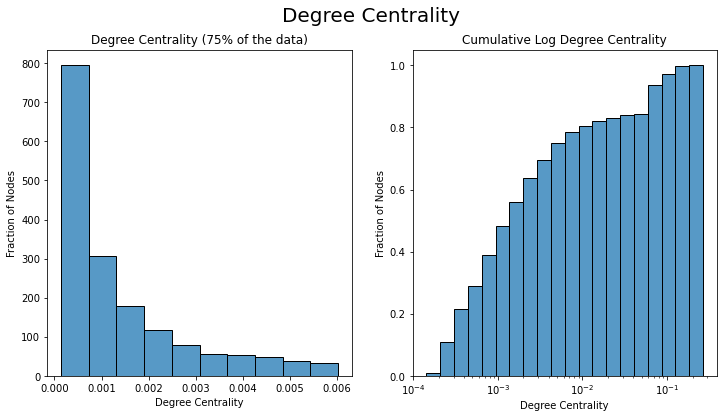

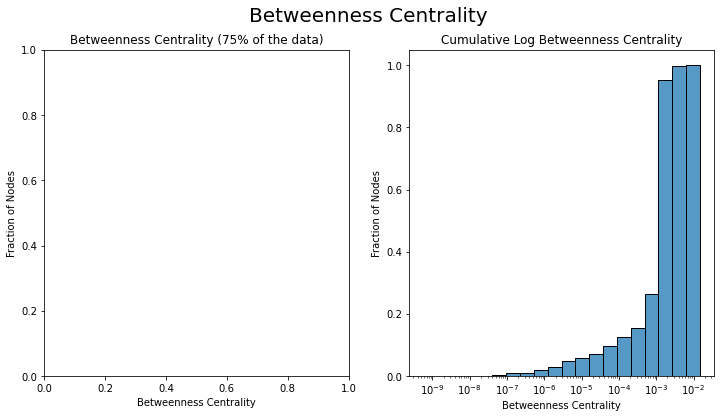

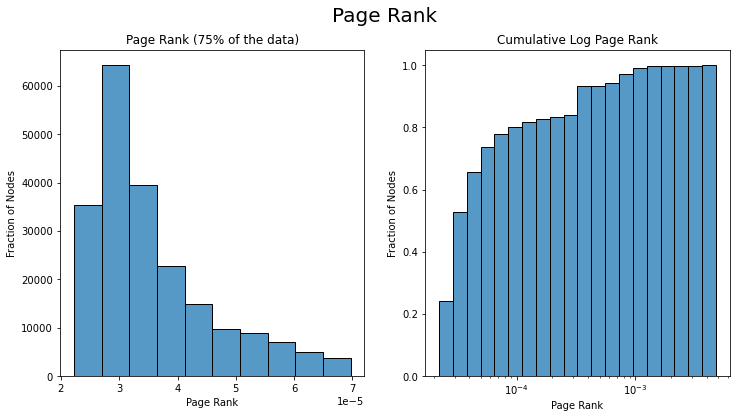

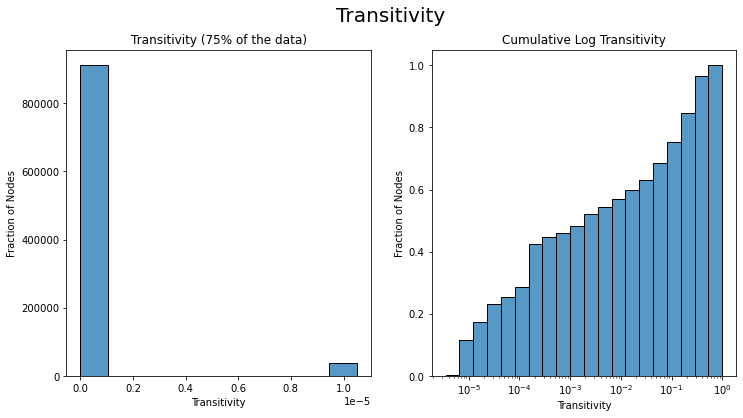

In [19]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [20]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.266571,eleanor-norton,0.014884,eleanor-norton,0.004768,House Energy and Commerce,1.000000,Authorizing the Office of General Counsel of t...
1,0.209592,brian-fitzpatrick,0.009326,brian-fitzpatrick,0.004412,House Judiciary,1.000000,Raising a question of the privileges of the Ho...
2,0.205154,steve-cohen,0.007410,sheila-jackson-lee,0.004271,House Ways and Means,1.000000,Senate Intelligence
3,0.201861,james-mcgovern,0.006338,james-mcgovern,0.003217,eleanor-norton,1.000000,Raising a question of the privileges of the Ho...
4,0.200286,janice-schakowsky,0.005400,mark-meadows,0.002956,House Education and Labor,1.000000,Raising a question of the privileges of the Ho...
5,0.197137,sheila-jackson-lee,0.005244,jamie-raskin,0.002658,House Oversight and Reform,1.000000,To amend the Federal Election Campaign Act of ...
6,0.197137,jamie-raskin,0.005125,steve-cohen,0.002451,House Natural Resources,0.833333,To amend the Higher Education Act of 1965 to e...
7,0.192412,raul-grijalva,0.004780,janice-schakowsky,0.002389,brian-fitzpatrick,0.833333,To amend the Higher Education Act of 1965 so t...
8,0.189263,alcee-hastings,0.004693,raul-grijalva,0.002030,House Financial Services,0.763636,"To amend title 31, United States Code, to prov..."
9,0.184681,barbara-lee,0.004606,don-young,0.001983,sheila-jackson-lee,0.714286,"To amend title 31, United States Code, to prov..."


## Connected Components Statistics

In [21]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 1
Size of the largest component: 6986


Text(0.5, 1.0, 'Connected Components')

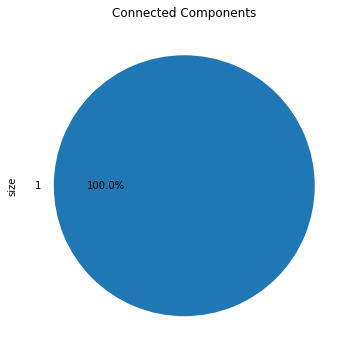

In [22]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components("weak"))], index=range(1,len(G.components("weak"))+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [23]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 4


,type,count,degree_avg,degree_median
Bill,Bill,5806,20.867379,8.0
Commitee,Commitee,95,94.694737,13.0
Member,Member,443,889.451467,860.0
Rollcall,Rollcall,642,443.733645,444.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

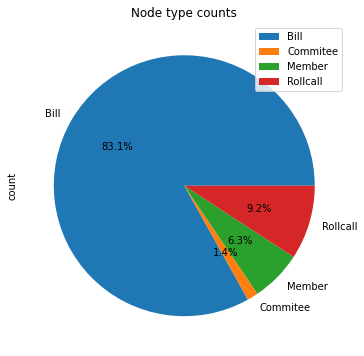

In [24]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

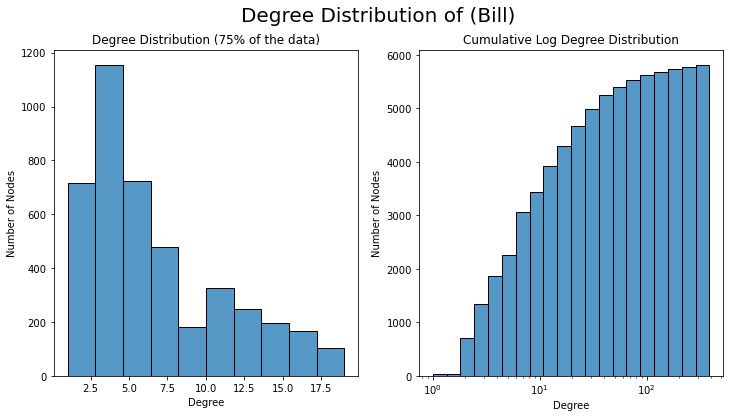

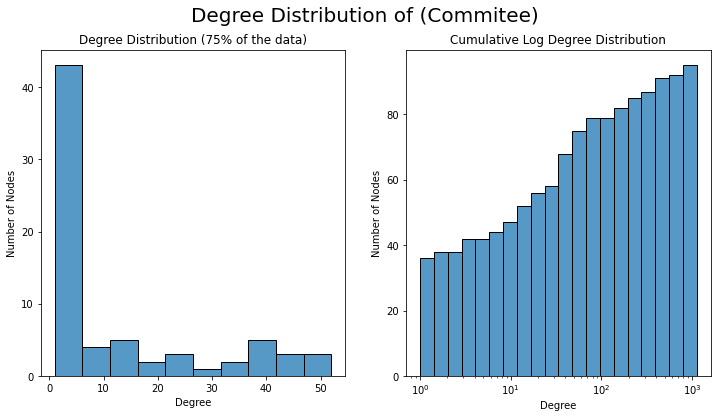

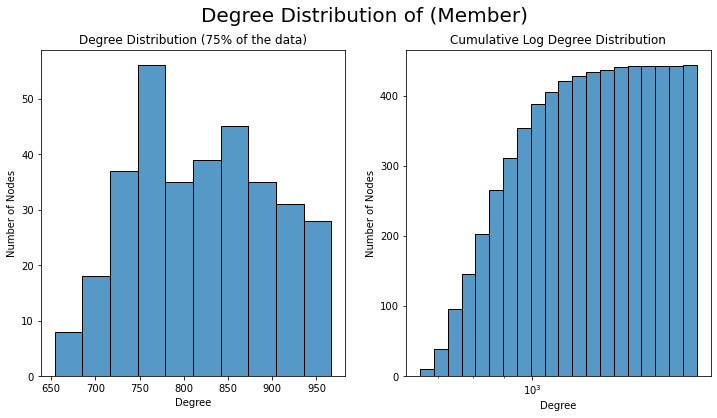

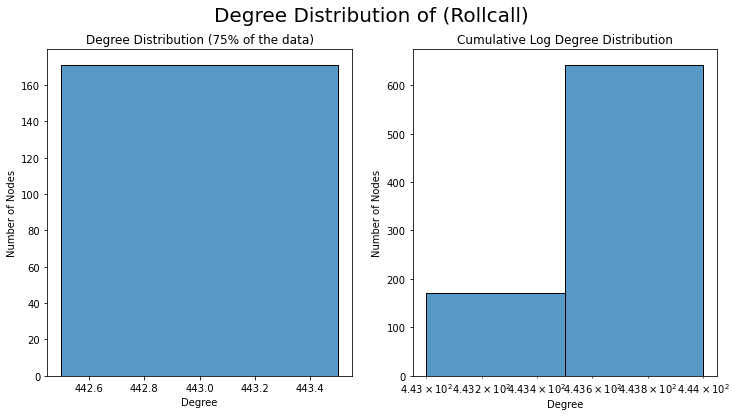

In [25]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [26]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Bill)


,value,label
0,386,"To amend title 10, United States Code, to repe..."
1,374,To amend the Internal Revenue Code of 1986 to ...
2,365,"To expand Americans' access to the ballot box,..."
3,362,To amend title XVIII of the Social Security Ac...
4,356,Opposing efforts to delegitimize the State of ...
5,338,"To amend title 38, United States Code, to clar..."
6,337,To extend authorization for the September 11th...
7,334,"To establish, fund, and provide for the use of..."
8,329,To amend title XVIII of the Social Security Ac...
9,317,To award Congressional Gold Medals to Katherin...


Top 10 Degree Nodes of Type (Commitee)


,value,label
0,1122,House Energy and Commerce
1,1016,House Judiciary
2,969,House Ways and Means
3,707,House Education and Labor
4,537,House Oversight and Reform
5,503,House Natural Resources
6,474,House Foreign Affairs
7,421,House Financial Services
8,376,House Transportation and Infrastructure
9,309,House Veterans' Affairs


Top 10 Degree Nodes of Type (Member)


,value,label
0,1862,eleanor-norton
1,1464,brian-fitzpatrick
2,1433,steve-cohen
3,1410,james-mcgovern
4,1399,janice-schakowsky
5,1377,jamie-raskin
6,1377,sheila-jackson-lee
7,1344,raul-grijalva
8,1322,alcee-hastings
9,1290,barbara-lee


Top 10 Degree Nodes of Type (Rollcall)


,value,label
0,444,On Agreeing to the Amendment
1,444,On Agreeing to the Amendment
2,444,On Agreeing to the Amendment
3,444,On Agreeing to the Amendment
4,444,On Agreeing to the Amendment
5,444,On Agreeing to the Amendment
6,444,On Agreeing to the Amendment
7,444,On Agreeing to the Amendment
8,444,On Agreeing to the Amendment
9,444,On Agreeing to the Amendment


### Edge Type Statistics

In [27]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 7


,type,count
COMMITEES_BILL,COMMITEES_BILL,8145
COSPONSORS,COSPONSORS,102964
MEMBER_OF_COMMITEE,MEMBER_OF_COMMITEE,851
RELATED_TO,RELATED_TO,1885
ROLLCALL_FOR,ROLLCALL_FOR,471
SPONSORS,SPONSORS,5806
VOTED_FOR,VOTED_FOR,284406


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

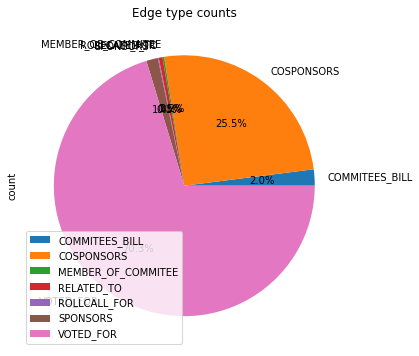

In [28]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [29]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [30]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Bill


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.054975,"To amend title 10, United States Code, to repe...",0.001857,To make improvements to certain defense and se...,0.000555,To authorize appropriations for fiscal year 20...,1.000000,Authorizing the Office of General Counsel of t...
1,0.053400,To amend the Internal Revenue Code of 1986 to ...,0.001348,To amend the Internal Revenue Code of 1986 to ...,0.000513,"To expand Americans' access to the ballot box,...",1.000000,Raising a question of the privileges of the Ho...
2,0.051825,To amend title XVIII of the Social Security Ac...,0.001282,"To establish, fund, and provide for the use of...",0.000378,"To amend title 10, United States Code, to repe...",1.000000,To amend the Federal Election Campaign Act of ...
3,0.050966,Opposing efforts to delegitimize the State of ...,0.001281,To extend authorization for the September 11th...,0.000363,To amend the Internal Revenue Code of 1986 to ...,1.000000,Raising a question of the privileges of the Ho...
4,0.048246,"To amend title 38, United States Code, to clar...",0.001281,To amend the Communications Act of 1934 to cla...,0.000355,To amend title XVIII of the Social Security Ac...,1.000000,Raising a question of the privileges of the Ho...
5,0.048103,To extend authorization for the September 11th...,0.001248,To amend part A of title IV of the Social Secu...,0.000351,Opposing efforts to delegitimize the State of ...,0.833333,To amend the Higher Education Act of 1965 to e...
6,0.047674,"To establish, fund, and provide for the use of...",0.001245,Opposing efforts to delegitimize the State of ...,0.000335,To extend authorization for the September 11th...,0.833333,To amend the Higher Education Act of 1965 so t...
7,0.047101,To amend title XVIII of the Social Security Ac...,0.001145,To award a Congressional Gold Medal to Greg Le...,0.000335,"To establish, fund, and provide for the use of...",0.763636,"To amend title 31, United States Code, to prov..."
8,0.045383,To amend the Internal Revenue Code of 1986 to ...,0.001104,To amend the Public Health Service Act to incr...,0.000331,"To amend title 38, United States Code, to clar...",0.714286,"To amend title 31, United States Code, to prov..."
9,0.045383,To award Congressional Gold Medals to Katherin...,0.001029,To amend the Internal Revenue Code of 1986 to ...,0.000330,To make improvements to certain defense and se...,0.700000,To amend the Higher Education Act of 1965 to e...


Top 10 Nodes by Statistic for Commitee


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.160630,House Energy and Commerce,0.001348,House Judiciary,0.004768,House Energy and Commerce,1.000000,Senate Intelligence
1,0.145455,House Judiciary,0.001325,House Ways and Means,0.004412,House Judiciary,0.025294,House Appropriations
2,0.138726,House Ways and Means,0.001146,House Energy and Commerce,0.004271,House Ways and Means,0.021978,House Ethics
3,0.101217,House Education and Labor,0.000611,House Education and Labor,0.002956,House Education and Labor,0.007688,House Administration
4,0.076879,House Oversight and Reform,0.000452,House Oversight and Reform,0.002658,House Oversight and Reform,0.007653,House Intelligence (Permanent Select)
5,0.072011,House Natural Resources,0.000308,House Natural Resources,0.002451,House Natural Resources,0.004505,"Senate Banking, Housing, and Urban Affairs"
6,0.067860,House Foreign Affairs,0.000184,House Foreign Affairs,0.002030,House Financial Services,0.002940,House Budget
7,0.060272,House Financial Services,0.000177,House Financial Services,0.001906,House Transportation and Infrastructure,0.002303,House Armed Services
8,0.053830,House Transportation and Infrastructure,0.000128,Education and Labor,0.001764,House Foreign Affairs,0.001705,House Small Business
9,0.044238,House Veterans' Affairs,0.000122,Agriculture,0.001284,House Veterans' Affairs,0.001216,House Rules


Top 10 Nodes by Statistic for Member


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.266571,eleanor-norton,0.014884,eleanor-norton,0.003217,eleanor-norton,0.000421,rosa-delauro
1,0.209592,brian-fitzpatrick,0.009326,brian-fitzpatrick,0.002389,brian-fitzpatrick,0.000289,adam-smith
2,0.205154,steve-cohen,0.007410,sheila-jackson-lee,0.001983,sheila-jackson-lee,0.000272,john-sarbanes
3,0.201861,james-mcgovern,0.006338,james-mcgovern,0.001909,james-mcgovern,0.000267,susan-davis
4,0.200286,janice-schakowsky,0.005400,mark-meadows,0.001879,steve-cohen,0.000261,greg-stanton
5,0.197137,sheila-jackson-lee,0.005244,jamie-raskin,0.001781,janice-schakowsky,0.000260,marcia-fudge
6,0.197137,jamie-raskin,0.005125,steve-cohen,0.001778,jamie-raskin,0.000259,doris-matsui
7,0.192412,raul-grijalva,0.004780,janice-schakowsky,0.001742,raul-grijalva,0.000259,pete-aguilar
8,0.189263,alcee-hastings,0.004693,raul-grijalva,0.001642,alcee-hastings,0.000258,stephen-lynch
9,0.184681,barbara-lee,0.004606,don-young,0.001630,barbara-lee,0.000255,jennifer-wexton


Top 10 Nodes by Statistic for Rollcall


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.063565,On Agreeing to the Amendment,0.001585,"On Motion to Suspend the Rules and Pass, as Am...",0.000427,On Motion to Suspend the Rules and Pass,0.003762,"On Motion to Suspend the Rules and Pass, as Am..."
1,0.063565,On Motion to Recommit with Instructions,0.001585,"On Motion to Suspend the Rules and Pass, as Am...",0.000426,On Motion to Suspend the Rules and Pass,0.003396,"On Motion to Suspend the Rules and Pass, as Am..."
2,0.063565,On Agreeing to the Amendment,0.001513,"On Motion to Suspend the Rules and Pass, as Am...",0.000426,On Motion to Suspend the Rules and Pass,0.003386,"On Motion to Suspend the Rules and Pass, as Am..."
3,0.063565,On Agreeing to the Amendment,0.001513,"On Motion to Suspend the Rules and Pass, as Am...",0.000426,On Motion to Suspend the Rules and Pass,0.003172,"On Motion to Suspend the Rules and Pass, as Am..."
4,0.063565,On Motion to Recommit with Instructions,0.001489,On Motion to Suspend the Rules and Pass,0.000425,"On Motion to Suspend the Rules and Pass, as Am...",0.003132,"On Motion to Suspend the Rules and Pass, as Am..."
5,0.063565,On Agreeing to the Amendment,0.001489,On Motion to Suspend the Rules and Pass,0.000425,"On Motion to Suspend the Rules and Pass, as Am...",0.003071,On Motion to Suspend the Rules and Pass
6,0.063565,"On Motion to Suspend the Rules and Pass, as Am...",0.001489,On Motion to Suspend the Rules and Pass,0.000425,On Passage,0.002898,"On Motion to Suspend the Rules and Pass, as Am..."
7,0.063565,On Agreeing to the Amendment,0.001489,On Motion to Suspend the Rules and Pass,0.000425,On Motion to Recommit with Instructions,0.002451,On Passage
8,0.063565,On Agreeing to the Amendment,0.001489,On Motion to Suspend the Rules and Pass,0.000425,On Passage,0.002451,On Motion to Recommit with Instructions
9,0.063565,On Agreeing to the Amendment,0.001489,On Motion to Suspend the Rules and Pass,0.000425,On Passage,0.002440,On Passage


# Clustering

## No Clustering Modularity

In [31]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [32]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.11875833829876306
Number of communities: 4


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

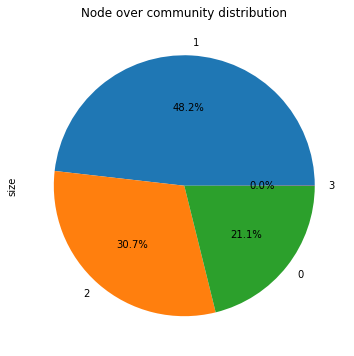

In [33]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.144596,mark-meadows,0.005400,mark-meadows,0.001436,mark-meadows,1.000000,Raising a question of the privileges of the Ho...
1,0.138869,tom-cole,0.004606,don-young,0.001230,don-young,0.370968,To promote the competitiveness of the United S...
2,0.138153,vicente-gonzalez,0.004011,andy-biggs,0.001193,tom-cole,0.214286,To amend the Small Business Act to clarify the...
3,0.138010,elise-stefanik,0.003751,jenniffer-gonzalez-colon,0.001145,paul-gosar,0.178571,To amend title IV-A of the Social Security Act...
4,0.136865,angie-craig,0.003612,steve-king,0.001140,elise-stefanik,0.178571,To prohibit the Secretary of Veterans Affairs ...
5,0.135290,cynthia-axne,0.003339,tom-cole,0.001115,jenniffer-gonzalez-colon,0.155556,To require an exercise related to terrorist an...
6,0.134860,max-rose,0.003211,paul-gosar,0.001098,vicente-gonzalez,0.142857,Proposing an amendment to the Constitution of ...
7,0.134717,ed-perlmutter,0.003170,raul-ruiz,0.001088,andy-biggs,0.142857,Proposing an amendment to the Constitution of ...
8,0.134717,al-lawson,0.003119,scott-tipton,0.001067,matt-gaetz,0.141026,Making appropriations for certain Federal empl...
9,0.134001,daniel-kildee,0.002994,bill-posey,0.001055,cynthia-axne,0.109890,To allow the Secretary of the Treasury to acce...


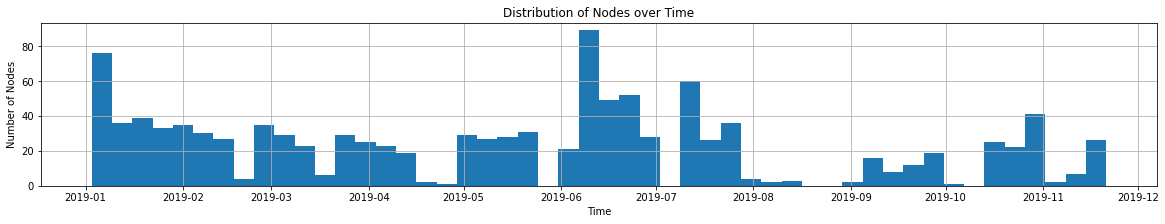

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.266571,eleanor-norton,0.014884,eleanor-norton,0.004768,House Energy and Commerce,1.000000,To amend the Federal Election Campaign Act of ...
1,0.205154,steve-cohen,0.007410,sheila-jackson-lee,0.004412,House Judiciary,1.000000,Authorizing the Office of General Counsel of t...
2,0.201861,james-mcgovern,0.006338,james-mcgovern,0.003217,eleanor-norton,0.833333,To amend the Higher Education Act of 1965 so t...
3,0.200286,janice-schakowsky,0.005244,jamie-raskin,0.002956,House Education and Labor,0.833333,To amend the Higher Education Act of 1965 to e...
4,0.197137,sheila-jackson-lee,0.005125,steve-cohen,0.002658,House Oversight and Reform,0.700000,To amend the Internal Revenue Code of 1986 to ...
5,0.197137,jamie-raskin,0.004780,janice-schakowsky,0.001983,sheila-jackson-lee,0.700000,To improve service to students and other parti...
6,0.192412,raul-grijalva,0.004693,raul-grijalva,0.001909,james-mcgovern,0.700000,To amend the Higher Education Act of 1965 to e...
7,0.189263,alcee-hastings,0.004550,barbara-lee,0.001879,steve-cohen,0.666667,To provide for a transition process to make el...
8,0.184681,barbara-lee,0.004535,darren-soto,0.001781,janice-schakowsky,0.666667,To direct the Secretary of Transportation to p...
9,0.183250,ro-khanna,0.004476,zoe-lofgren,0.001778,jamie-raskin,0.666667,To direct the Secretary of Education to assign...


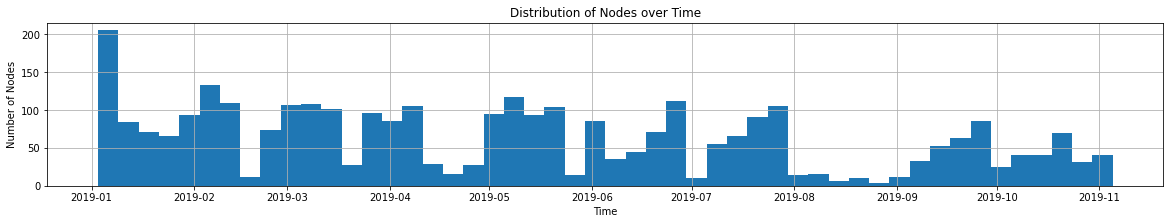

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.209592,brian-fitzpatrick,0.009326,brian-fitzpatrick,0.004271,House Ways and Means,1.000000,Senate Intelligence
1,0.148890,josh-harder,0.003505,peter-king,0.002451,House Natural Resources,0.763636,"To amend title 31, United States Code, to prov..."
2,0.143880,gerald-connolly,0.003256,josh-harder,0.002389,brian-fitzpatrick,0.714286,"To amend title 31, United States Code, to prov..."
3,0.143880,jefferson-van-drew,0.002941,daniel-lipinski,0.002030,House Financial Services,0.690909,"To amend title 31, United States Code, to prov..."
4,0.142878,david-trone,0.002802,jefferson-van-drew,0.001906,House Transportation and Infrastructure,0.666667,To require geographical diversity in the provi...
5,0.142162,brad-sherman,0.002548,gerald-connolly,0.001764,House Foreign Affairs,0.666667,Calling upon the leadership of the Government ...
6,0.141446,peter-king,0.002443,brad-sherman,0.001284,House Veterans' Affairs,0.666667,Making further continuing appropriations for f...
7,0.138869,terri-sewell,0.002308,terri-sewell,0.001282,House Armed Services,0.666667,"To amend title 46, United States Code, to adju..."
8,0.138726,House Ways and Means,0.002240,charlie-crist,0.001263,josh-harder,0.666667,Proposing an amendment to the Constitution of ...
9,0.138440,daniel-lipinski,0.001951,elaine-luria,0.001249,peter-king,0.666667,To require notice from the Secretary of the Tr...


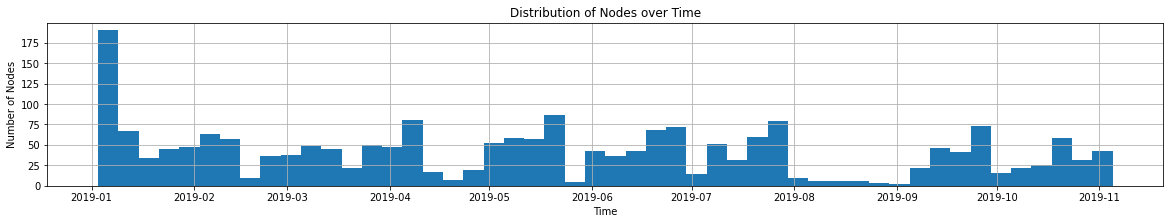

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000286,Raising a question of the privileges of the Ho...,0.0,Raising a question of the privileges of the Ho...,0.000039,Raising a question of the privileges of the Ho...,1.0,Raising a question of the privileges of the Ho...
1,0.000286,Raising a question of the privileges of the Ho...,0.0,Raising a question of the privileges of the Ho...,0.000039,Raising a question of the privileges of the Ho...,1.0,Raising a question of the privileges of the Ho...


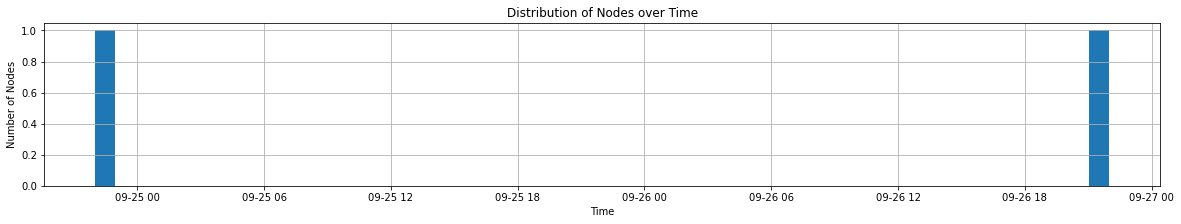

In [34]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [35]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: -1.2278566057943922e-11
Number of communities: 2


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

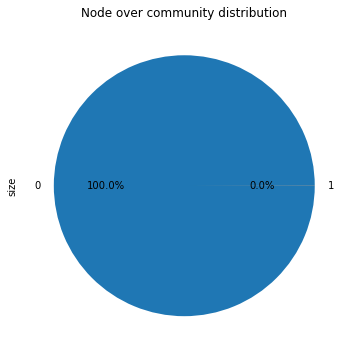

In [36]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.266571,eleanor-norton,0.014884,eleanor-norton,0.004768,House Energy and Commerce,1.000000,Raising a question of the privileges of the Ho...
1,0.209592,brian-fitzpatrick,0.009326,brian-fitzpatrick,0.004412,House Judiciary,1.000000,To amend the Federal Election Campaign Act of ...
2,0.205154,steve-cohen,0.007410,sheila-jackson-lee,0.004271,House Ways and Means,1.000000,Authorizing the Office of General Counsel of t...
3,0.201861,james-mcgovern,0.006338,james-mcgovern,0.003217,eleanor-norton,1.000000,Senate Intelligence
4,0.200286,janice-schakowsky,0.005400,mark-meadows,0.002956,House Education and Labor,1.000000,Raising a question of the privileges of the Ho...
5,0.197137,sheila-jackson-lee,0.005244,jamie-raskin,0.002658,House Oversight and Reform,0.833333,To amend the Higher Education Act of 1965 so t...
6,0.197137,jamie-raskin,0.005125,steve-cohen,0.002451,House Natural Resources,0.833333,To amend the Higher Education Act of 1965 to e...
7,0.192412,raul-grijalva,0.004780,janice-schakowsky,0.002389,brian-fitzpatrick,0.763636,"To amend title 31, United States Code, to prov..."
8,0.189263,alcee-hastings,0.004693,raul-grijalva,0.002030,House Financial Services,0.714286,"To amend title 31, United States Code, to prov..."
9,0.184681,barbara-lee,0.004606,don-young,0.001983,sheila-jackson-lee,0.700000,To improve service to students and other parti...


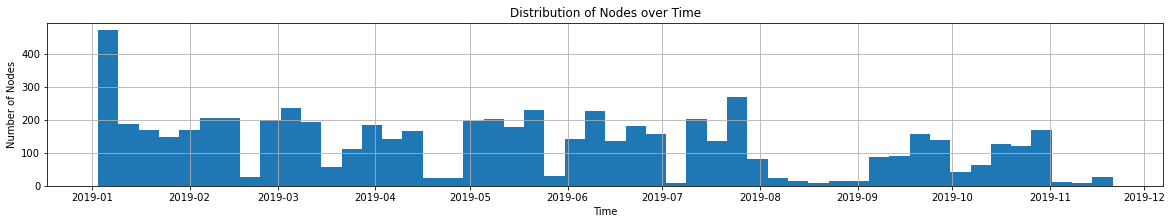

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000286,Raising a question of the privileges of the Ho...,0.0,Raising a question of the privileges of the Ho...,0.000039,Raising a question of the privileges of the Ho...,1.0,Raising a question of the privileges of the Ho...


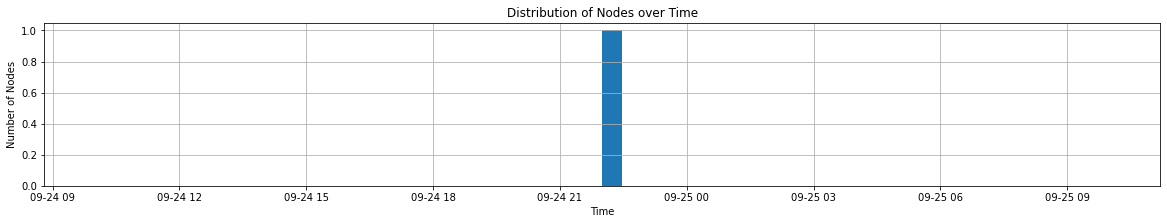

In [37]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')